# Kartu-Verb 

Kartu-Verbs database contains information about Georgian inflected verbs and it's characteristics.
In a csv file we have information in the following fields: 

* form: Inflected form of a Georgian verb
* tense_in_paradigm: Tense for the inflected form
* person: Person for the inflected form (1, 2, 3)
* number: Number for the inflected form (sg, pl)
* preverb: Preverb for the inflected form
* pre2: Preradical for the inflected form
* root: Root for the inflected form
* sf2: Stem formant for the inflected form
* caus_sf: causative Stem formant for the inflected form
* ending: Ending for the inflected form
* tsch_class: Tschkhenkeli Class
* morph_type: morphology type
* id: Id in Clarino database to keep link to the corresponding croot
* sub_id: Id in Clarino database to keep link to the corresponding verb paradigm
* vn2: Verbal Noun for the inflected form

Our goal is to train a model which will predict a Verbal Noun based on the following information: form, tense_in_paradigm, person, number, preverb, pre2, root, sf2, caus_sf, ending, tsch_class, orph_type and sub_id


# Import Libraries

Import the usual libraries for pandas and plotting. You can import sklearn later on.

In [1]:
import pandas as pd
import numpy as np
import re
%config InlineBackend.figure_formats = ['svg'] #pdf,svg
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Get the Data

Read in the kartu-verb.csv file and set it to a data frame called kv.

In [2]:
kv = pd.read_csv('data20230408_15f_vn2PRESENT.csv', sep=';')

Check the head of kv

In [3]:
kv.head(11)

,form,tense_in_paradigm,person,number,preverb,pre2,root,sf2,caus_sf,ending,tsch_class,morph_type,sub_id,id,vn2
0,ვაბეზარობ,present,1,sg,-,ვ,აბეზარ,ობ,-,-,MV,active,1-1,1,აბეზარობა
1,ჰაბეზარობ,present,2,sg,-,ჰ,აბეზარ,ობ,-,-,MV,active,1-1,1,აბეზარობა
2,აბეზარობ,present,2,sg,-,-,აბეზარ,ობ,-,-,MV,active,1-1,1,აბეზარობა
3,ჰაბეზარობს,present,3,sg,-,ჰ,აბეზარ,ობ,-,ს,MV,active,1-1,1,აბეზარობა
4,აბეზარობს,present,3,sg,-,-,აბეზარ,ობ,-,ს,MV,active,1-1,1,აბეზარობა
5,ვაბეზარობთ,present,1,pl,-,ვ,აბეზარ,ობ,-,თ,MV,active,1-1,1,აბეზარობა
6,ჰაბეზარობთ,present,2,pl,-,ჰ,აბეზარ,ობ,-,თ,MV,active,1-1,1,აბეზარობა
7,აბეზარობთ,present,2,pl,-,-,აბეზარ,ობ,-,თ,MV,active,1-1,1,აბეზარობა
8,ჰაბეზარობენ,present,3,pl,-,ჰ,აბეზარ,ობ,-,ენ,MV,active,1-1,1,აბეზარობა
9,აბეზარობენ,present,3,pl,-,-,აბეზარ,ობ,-,ენ,MV,active,1-1,1,აბეზარობა


Use info on kv

In [4]:
kv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785677 entries, 0 to 3785676
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   form               object
 1   tense_in_paradigm  object
 2   person             int64 
 3   number             object
 4   preverb            object
 5   pre2               object
 6   root               object
 7   sf2                object
 8   caus_sf            object
 9   ending             object
 10  tsch_class         object
 11  morph_type         object
 12  sub_id             object
 13  id                 int64 
 14  vn2                object
dtypes: int64(2), object(13)
memory usage: 433.2+ MB


* Create a function to plot Missing data Ration % in kv

In [5]:
def plot_nan(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        print('How many elements are present in each files:')
        print(len(df)-df.isnull().sum())
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data=round(missing_data,0)
        print(missing_data) 
        ax=missing_data.plot.barh(figsize=(10,3))
        ax.bar_label(ax.containers[0]) #rotation=270
    else:
        print('No NAN found')

Kartu Verb Dataframe shape (rows,colomns) = (3785677, 15)
How many elements are present in each files:
form                 3785677
tense_in_paradigm    3785677
person               3785677
number               3785677
preverb              2221859
pre2                 3378255
root                 3785677
sf2                  1949319
caus_sf                77922
ending               3704340
tsch_class           3785677
morph_type           3785677
sub_id               3785677
id                   3785677
vn2                  3785677
dtype: int64
         Missing Ratio %
caus_sf             98.0
sf2                 49.0
preverb             41.0
pre2                11.0
ending               2.0


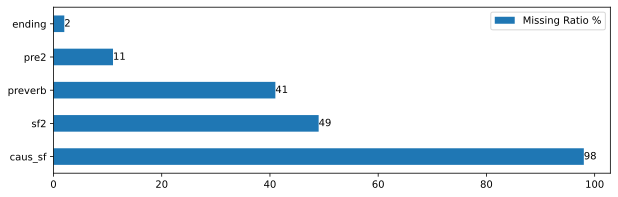

In [6]:
print('Kartu Verb Dataframe shape (rows,colomns) =',kv.shape)
plot_nan(kv.replace('-',np.nan))

Machine learning algorithmes can't dial with texts. Kartu-Verbs database contains texts in Georgian, so we have to convert texts into numeric. In addition dataframe shouldn't contain empty values, in our case emply value is givven with dash "-".
So we:
* replaced Georgian strings with equvalent binary representation
* replaced empty values ('-') with 0
* replaced 11 tense_in_paradigm with [1,2,3,4,5,6,7,8,9,10,11]
* replaced 28 tsch_class with [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
* replaced 5 morph_type with [0,1,2,3,4]

P.S. For simplicity we substituted original value of tsch_class with the following.

original: IV1, IV2, IV3, IV4, KT, KT (nur mit i.O.), KT (OR), MV, P1, P2, P3, RM1, RM1 (OR), RM2, RM2 (OR), RM3, RM3 (OR), RM4, RM4(OR),RP1,RP1(mit,RP1(ohnei.O.),RP1(OR),RP2,RP2, (OR),RP3,RP3(OR),RP4,RP4(OR),RP5,RP5(OR),RP6,RP6, (OR),RP7,RP7(ohnei.O.),RP7(OR),T1,T1(OR),T2,T2(OR),T3, T3 (nur mit i.O.), T3 (OR), T4, T4 (nur mit i.O.), T4 (OR), T5, T5 (nur mit i.O.), T5 (OR), T5 (OR) (nur mit i.O.), ZP1, ZP2, ZP3

substitution: IV1, IV2, IV3, IV4, KT, MV, P1, P2, P3, RM1, RM2, RM3, RM4, RP1, RP2, RP3, RP4, RP5, RP6, RP7, T1, T2, T3, T4, T5, ZP1, ZP2, ZP3


In [7]:
kv['tense_in_paradigm'].replace(['present','imperfect','conj-present','future','conditional','conj-future','aorist','optative','perfect','pluperfect','conj-perfect'],[1,2,3,4,5,6,7,8,9,10,11], inplace=True)
kv['morph_type'].replace(['-','active','causative','passive','stative-passive'],[0,1,2,3,4], inplace=True)
kv['tsch_class'].replace(['IV1','IV2','IV3','IV4','KT','MV','P1','P2','P3','RM1','RM2','RM3','RM4','RP1','RP2','RP3','RP4','RP5','RP6','RP7','T1','T2','T3','T4','T5','ZP1','ZP2','ZP3'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], inplace=True)
kv['number'].replace(['sg','pl'],[1,2],inplace=True)
kv['preverb'].replace(['-'],['0'],inplace=True)
kv['pre2'].replace(['-'],['0'],inplace=True)
kv['root'].replace(['-'],['0'],inplace=True)
kv['sf2'].replace(['-'],['0'],inplace=True)
kv['caus_sf'].replace(['-'],['0'],inplace=True)
kv['ending'].replace(['-'],['0'],inplace=True)
kv['sub_id'].replace('.*-','',regex=True,inplace=True)
kv['vn2'].replace(['-'],['0'],inplace=True)

In [8]:
print(kv['sub_id'])

0          1
1          1
2          1
3          1
4          1
          ..
3785672    2
3785673    2
3785674    2
3785675    2
3785676    2
Name: sub_id, Length: 3785677, dtype: object


* Georgian character is 3 byte long in utf-8 encoding. First 2 bytes are redondant. For conversion we take last bytes and sum their decimal representation. So we created a function for conversion text to number;

In [9]:
def str2dec(x): #To sum last byte decimal versions for each character of a given string x
    s=0
    for i in x:
        s+=ord(i.encode('utf8')[-1:])
    return s

* After we added new fields to kv dataframe: formd, preverbd, pre2d, rootd, caus_sfd, sf2d and endingd for coresponding decimal representations.

In [10]:
#convert Georgian string as sum of characters decimal representation
kv['formd'] = kv['form'].apply(lambda x: str2dec(x))
kv['preverbd'] = kv['preverb'].apply(lambda x: str2dec(x))
kv['pre2d'] = kv['pre2'].apply(lambda x: str2dec(x))
kv['rootd'] = kv['root'].apply(lambda x: str2dec(x))
kv['sf2d'] = kv['sf2'].apply(lambda x: str2dec(x))
kv['caus_sfd'] = kv['sf2'].apply(lambda x: str2dec(x))
kv['endingd'] = kv['ending'].apply(lambda x: str2dec(x))
kv['vn2d'] = kv['vn2'].apply(lambda x: str2dec(x))

Let's encode vn2d just enumereting from 1 to N, and keep this encoding information in a dictionnary index_vn2

In [11]:
index_vn2 = {}
vn2_new_list = []

for i in kv['vn2']:
    if i not in index_vn2:
        index_vn2[i] = len(index_vn2)
    vn2_new_list.append(index_vn2[i])

kv['vn2d']=vn2_new_list

In [12]:
print(index_vn2)

{'აბეზარობა': 0, 'გააბეჩხრება': 1, 'გააბეჩხრებინება': 2, 'აბრაგობა': 3, 'გააბრაგება': 4, 'გაადამიანება': 5, 'გაადამიანებინება': 6, 'გადაადგილება': 7, 'გადაადგილებინება': 8, 'გაადვილება': 9, 'ადვილება': 10, 'გაადვილებინება': 11, 'ავობა': 12, 'გაავება': 13, 'ავადმყოფობა': 14, 'დაავადმყოფება': 15, 'მოავადმყოფება': 16, 'ავაზაკობა': 17, 'გაავაზაკება': 18, 'დაავანსება': 19, 'დაავანსებინება': 20, 'ავანჩავანობა': 21, 'ავგულობა': 22, 'გაავგულება': 23, 'ავდრობა': 24, 'გაავდრება': 25, 'გაავზნიანება': 26, 'გაავზნიანებინება': 27, 'ავკაცობა': 28, 'გაავკაცება': 29, 'ავყიაობა': 30, 'გაავყიავება': 31, 'გააზატება': 32, 'გააზატებინება': 33, 'აზიზობა': 34, 'გააზიზება': 35, 'გააზნაურება': 36, 'გააზნაურებინება': 37, 'აზრება': 38, 'გააზრება': 39, 'მოაზრება': 40, 'გააზრიანება': 41, 'გააზრიანებინება': 42, 'აზროვნება': 43, 'გაათასება': 44, 'გაათასებინება': 45, 'გაათასკეცება': 46, 'გაათასკეცებინება': 47, 'გაათკეცება': 48, 'გაათკეცებინება': 49, 'ააირება': 50, 'ააირებინება': 51, 'აალება': 52, 'დაალება': 53, 'აალებ

In [13]:
kv['vn2d']=kv['vn2d'].astype('int16')

In [14]:
print(kv['vn2'],kv['vn2d'])
#print(kv['vn2d'])

0          აბეზარობა
1          აბეზარობა
2          აბეზარობა
3          აბეზარობა
4          აბეზარობა
             ...    
3785672      დაბუება
3785673      დაბუება
3785674      დაბუება
3785675      დაბუება
3785676      დაბუება
Name: vn2, Length: 3785677, dtype: object 0              0
1              0
2              0
3              0
4              0
           ...  
3785672    15685
3785673    15685
3785674    15685
3785675    15685
3785676    15685
Name: vn2d, Length: 3785677, dtype: int16


* we can save apart corresponding text and numver representaion for forms and vebal nouns in a separeted files for further inversigation.

In [15]:
kv[['form','formd']].to_csv('form_formd.csv',sep=',')
kv[['vn2','vn2d']].to_csv('vn2_vn2d.csv',sep=',')

In [16]:
kv.describe()

,tense_in_paradigm,person,number,tsch_class,morph_type,id,formd,preverbd,pre2d,rootd,sf2d,caus_sfd,endingd,vn2d
count,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06
mean,6.321901e+00,2.106105e+00,1.531630e+00,1.299764e+01,1.724828e+00,2.075319e+03,1.738914e+03,2.244644e+02,2.059264e+02,6.621484e+02,1.602746e+02,1.602746e+02,5.299495e+02,7.998322e+03
std,3.130278e+00,8.148861e-01,4.989986e-01,7.867935e+00,8.343592e-01,1.065771e+03,4.750580e+02,1.826369e+02,1.065457e+02,2.277353e+02,1.163360e+02,1.163360e+02,3.045810e+02,4.502761e+03
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.950000e+02,4.800000e+01,4.800000e+01,1.450000e+02,4.800000e+01,4.800000e+01,4.800000e+01,0.000000e+00
25%,3.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00,1.145000e+03,1.386000e+03,4.800000e+01,1.440000e+02,4.770000e+02,4.800000e+01,4.800000e+01,2.990000e+02,4.115000e+03
50%,7.000000e+00,2.000000e+00,2.000000e+00,1.300000e+01,1.000000e+00,2.151000e+03,1.694000e+03,2.900000e+02,1.630000e+02,6.320000e+02,1.490000e+02,1.490000e+02,4.510000e+02,8.078000e+03
75%,9.000000e+00,3.000000e+00,2.000000e+00,2.000000e+01,2.000000e+00,3.029000e+03,2.048000e+03,3.120000e+02,2.940000e+02,7.920000e+02,2.930000e+02,2.930000e+02,7.490000e+02,1.199800e+04
max,1.100000e+01,3.000000e+00,2.000000e+00,2.700000e+01,4.000000e+00,3.847000e+03,4.402000e+03,1.239000e+03,1.196000e+03,2.776000e+03,3.210000e+02,3.210000e+02,1.831000e+03,1.568500e+04


In [17]:
kv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785677 entries, 0 to 3785676
Data columns (total 23 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   form               object
 1   tense_in_paradigm  int64 
 2   person             int64 
 3   number             int64 
 4   preverb            object
 5   pre2               object
 6   root               object
 7   sf2                object
 8   caus_sf            object
 9   ending             object
 10  tsch_class         int64 
 11  morph_type         int64 
 12  sub_id             object
 13  id                 int64 
 14  vn2                object
 15  formd              int64 
 16  preverbd           int64 
 17  pre2d              int64 
 18  rootd              int64 
 19  sf2d               int64 
 20  caus_sfd           int64 
 21  endingd            int64 
 22  vn2d               int16 
dtypes: int16(1), int64(13), object(9)
memory usage: 642.6+ MB


# Setting up the Data
* let's keep only number represantation into new dataframe called kn_n
* and rename tense_in_paradigm to tense for simplicity

In [18]:
kv_n = kv.loc[:,['formd','tense_in_paradigm','person','number','preverbd','pre2d','rootd','sf2d','caus_sfd','endingd','tsch_class','morph_type','sub_id','id','vn2d']]
kv_n.rename(columns={'tense_in_paradigm':'tense'}, inplace=True) # just rename 'tense_in_paradigm' with 'tense' for simplicity

Delete kv dataframe to free up RAM

In [19]:
del kv

In [20]:
kv_n.describe()

,formd,tense,person,number,preverbd,pre2d,rootd,sf2d,caus_sfd,endingd,tsch_class,morph_type,id,vn2d
count,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06,3.785677e+06
mean,1.738914e+03,6.321901e+00,2.106105e+00,1.531630e+00,2.244644e+02,2.059264e+02,6.621484e+02,1.602746e+02,1.602746e+02,5.299495e+02,1.299764e+01,1.724828e+00,2.075319e+03,7.998322e+03
std,4.750580e+02,3.130278e+00,8.148861e-01,4.989986e-01,1.826369e+02,1.065457e+02,2.277353e+02,1.163360e+02,1.163360e+02,3.045810e+02,7.867935e+00,8.343592e-01,1.065771e+03,4.502761e+03
min,2.950000e+02,1.000000e+00,1.000000e+00,1.000000e+00,4.800000e+01,4.800000e+01,1.450000e+02,4.800000e+01,4.800000e+01,4.800000e+01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.386000e+03,3.000000e+00,1.000000e+00,1.000000e+00,4.800000e+01,1.440000e+02,4.770000e+02,4.800000e+01,4.800000e+01,2.990000e+02,5.000000e+00,1.000000e+00,1.145000e+03,4.115000e+03
50%,1.694000e+03,7.000000e+00,2.000000e+00,2.000000e+00,2.900000e+02,1.630000e+02,6.320000e+02,1.490000e+02,1.490000e+02,4.510000e+02,1.300000e+01,1.000000e+00,2.151000e+03,8.078000e+03
75%,2.048000e+03,9.000000e+00,3.000000e+00,2.000000e+00,3.120000e+02,2.940000e+02,7.920000e+02,2.930000e+02,2.930000e+02,7.490000e+02,2.000000e+01,2.000000e+00,3.029000e+03,1.199800e+04
max,4.402000e+03,1.100000e+01,3.000000e+00,2.000000e+00,1.239000e+03,1.196000e+03,2.776000e+03,3.210000e+02,3.210000e+02,1.831000e+03,2.700000e+01,4.000000e+00,3.847000e+03,1.568500e+04


In [21]:
kv_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785677 entries, 0 to 3785676
Data columns (total 15 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   formd       int64 
 1   tense       int64 
 2   person      int64 
 3   number      int64 
 4   preverbd    int64 
 5   pre2d       int64 
 6   rootd       int64 
 7   sf2d        int64 
 8   caus_sfd    int64 
 9   endingd     int64 
 10  tsch_class  int64 
 11  morph_type  int64 
 12  sub_id      object
 13  id          int64 
 14  vn2d        int16 
dtypes: int16(1), int64(13), object(1)
memory usage: 411.6+ MB


change variable type to be less heavy in RAM

In [22]:
kv_n.loc[:,'formd']=kv_n.loc[:,'formd'].astype('int16')
kv_n.loc[:,'tense']=kv_n.loc[:,'tense'].astype('byte')
kv_n.loc[:,'person']=kv_n.loc[:,'person'].astype('byte')
kv_n.loc[:,'number']=kv_n.loc[:,'number'].astype('byte')
kv_n.loc[:,'preverbd']=kv_n.loc[:,'preverbd'].astype('int16')
kv_n.loc[:,'pre2d']=kv_n.loc[:,'pre2d'].astype('int16')
kv_n.loc[:,'rootd']=kv_n.loc[:,'rootd'].astype('int16')
kv_n.loc[:,'sf2d']=kv_n.loc[:,'sf2d'].astype('int16')
kv_n.loc[:,'caus_sfd']=kv_n.loc[:,'caus_sfd'].astype('int16')
kv_n.loc[:,'endingd']=kv_n.loc[:,'endingd'].astype('int16')
kv_n.loc[:,'tsch_class']=kv_n.loc[:,'tsch_class'].astype('int16')
kv_n.loc[:,'morph_type']=kv_n.loc[:,'morph_type'].astype('int16')
kv_n.loc[:,'id']=kv_n.loc[:,'id'].astype('int16')
kv_n.loc[:,'sub_id']=kv_n.loc[:,'sub_id'].astype('int16') #float16
kv_n.loc[:,'vn2d']=kv_n.loc[:,'vn2d'].astype('int16')

Let's have a look to the new dataframe

In [23]:
kv_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785677 entries, 0 to 3785676
Data columns (total 15 columns):
 #   Column      Dtype
---  ------      -----
 0   formd       int16
 1   tense       int8 
 2   person      int8 
 3   number      int8 
 4   preverbd    int16
 5   pre2d       int16
 6   rootd       int16
 7   sf2d        int16
 8   caus_sfd    int16
 9   endingd     int16
 10  tsch_class  int16
 11  morph_type  int16
 12  sub_id      int16
 13  id          int16
 14  vn2d        int16
dtypes: int16(12), int8(3)
memory usage: 97.5 MB


In [24]:
print(kv_n)

         formd  tense  person  number  preverbd  pre2d  rootd  sf2d  caus_sfd  \
0         1342      1       1       1        48    149    891   302       302   
1         1369      1       2       1        48    176    891   302       302   
2         1193      1       2       1        48     48    891   302       302   
3         1530      1       3       1        48    176    891   302       302   
4         1354      1       3       1        48     48    891   302       302   
...        ...    ...     ...     ...       ...    ...    ...   ...       ...   
3785672   2134     11       1       2       291    149    457   293       293   
3785673   2161     11       2       2       291    176    457   293       293   
3785674   1985     11       2       2       291     48    457   293       293   
3785675   2166     11       3       2       291    176    457   293       293   
3785676   1990     11       3       2       291     48    457   293       293   

         endingd  tsch_clas

## Decision Tree Model - Solution

Let's start by training a single decision tree first!

## Train Test Split

Now its time to split our data into a training set and a testing set!

** Use sklearn to split your data into a training set and a testing set as we've done in the past.**

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X = kv_n.drop('vn2d',axis=1)
y = kv_n['vn2d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print(X_test)
print(y)

         formd  tense  person  number  preverbd  pre2d  rootd  sf2d  caus_sfd  \
257583    1509      1       3       1        48    144    911   293       293   
2282296   1362      2       2       1        48    148    465    48        48   
559941    2263      6       3       2       316    144    454    48        48   
3490441   1574      4       3       1       316     48    804   293       293   
2148889   1719     11       1       2       312    443    646    48        48   
...        ...    ...     ...     ...       ...    ...    ...   ...       ...   
927911    1792      4       3       1       290     48    918    48        48   
378631    1942      6       1       2       456    301    446   293       293   
3229386   1388      2       3       1        48     48    804   293       293   
861842    2018      1       1       1        48    293    975   149       149   
2883812   2398      5       3       2       581    144    621    48        48   

         endingd  tsch_clas

** Import DecisionTreeClassifier**

In [28]:
from sklearn.tree import DecisionTreeClassifier

**Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.**

In [29]:
dtree = DecisionTreeClassifier()

In [30]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

## Predictions and Evaluation of Decision Tree
**Create predictions from the test set and create a classification report and a confusion matrix.**

In [31]:
predictions = dtree.predict(X_test)

In [32]:
from sklearn.metrics import classification_report,confusion_matrix

In [33]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        82
           5       1.00      1.00      1.00        56
           6       1.00      1.00      1.00        30
           7       1.00      1.00      1.00        67
           8       1.00      1.00      1.00        36
           9       1.00      1.00      1.00        82
          10       1.00      1.00      1.00         7
          11       1.00      1.00      1.00        28
          12       1.00      1.00      1.00        25
          13       1.00      1.00      1.00        98
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00       121
          16       1.00      1.00      1.00        23
          17       1.00    

To save the clssificaion report in a file

In [34]:
report = classification_report(y_test,predictions)
report_path = "report7.txt"
text_file = open(report_path,"w")
n = text_file.write(report)
text_file.close()

In [35]:
print(confusion_matrix(y_test,predictions))
cm = confusion_matrix(y_test,predictions)

[[20  0  0 ...  0  0  0]
 [ 0 44  0 ...  0  0  0]
 [ 0  0 28 ...  0  0  0]
 ...
 [ 0  0  0 ... 43  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0 21]]


# Prepare test data from a file

We have data20230408_14f_vn2NOTpresent.csv file that contain all the field but Verbal Noun. 
It's interesting to know how our trained model can predict missings vn2s.

data20230408_14f_vn2NOTpresent.csv contain 610734 lines

## Get the Data
Read in the kartu-verb.csv file and set it to a data frame called kv.

In [36]:
X_test2 = pd.read_csv('data20230415_TEST_305.csv', sep=';')

Check the head of kv

In [37]:
print(X_test2)
Solution = X_test2.copy()

               form tense_in_paradigm  person number preverb pre2     root  \
0      ვაამხანაგებთ           present       1     pl       -   ვა  ამხანაგ   
1    მიგეახლოვებინა        pluperfect       2     sg      მი   გე     ახლო   
2       ჩააბარებდენ       conj-future       3     pl      ჩა    ა      ბარ   
3        ჩაჰბარდება            future       3     sg      ჩა    ჰ      ბარ   
4      მოუბარბაციათ           perfect       3     pl      მო    უ   ბარბაც   
..              ...               ...     ...    ...     ...  ...      ...   
252         ხრიდნენ      conj-present       3     pl       -    -       ხრ   
253    ახრევინებდენ      conj-present       3     pl       -    ა       ხრ   
254  გადმოაჯდებოდეს       conj-future       3     sg   გადმო    ა       ჯდ   
255       დაგიჯეროს          optative       2     pl      და   გი      ჯერ   
256   აგაძაგძაგებდა       conditional       2     sg       ა   გა   ძაგძაგ   

    sf2 caus_sf  ending tsch_class morph_type   sub_id    id   

In [38]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   form               257 non-null    object
 1   tense_in_paradigm  257 non-null    object
 2   person             257 non-null    int64 
 3   number             257 non-null    object
 4   preverb            257 non-null    object
 5   pre2               257 non-null    object
 6   root               257 non-null    object
 7   sf2                257 non-null    object
 8   caus_sf            257 non-null    object
 9   ending             257 non-null    object
 10  tsch_class         257 non-null    object
 11  morph_type         257 non-null    object
 12  sub_id             257 non-null    object
 13  id                 257 non-null    int64 
 14  vn2                257 non-null    object
dtypes: int64(2), object(13)
memory usage: 30.2+ KB


Prepare data and convert texts into numeric

In [39]:
X_test2['tense_in_paradigm'].replace(['present','imperfect','conj-present','future','conditional','conj-future','aorist','optative','perfect','pluperfect','conj-perfect'],[1,2,3,4,5,6,7,8,9,10,11], inplace=True)
X_test2['morph_type'].replace(['-','active','causative','passive','stative-passive'],[0,1,2,3,4], inplace=True)
X_test2['tsch_class'].replace(['IV1','IV2','IV3','IV4','KT','MV','P1','P2','P3','RM1','RM2','RM3','RM4','RP1','RP2','RP3','RP4','RP5','RP6','RP7','T1','T2','T3','T4','T5','ZP1','ZP2','ZP3'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], inplace=True)
X_test2['number'].replace(['sg','pl'],[1,2],inplace=True)
X_test2['preverb'].replace(['-'],['0'],inplace=True)
X_test2['pre2'].replace(['-'],['0'],inplace=True)
X_test2['root'].replace(['-'],['0'],inplace=True)
X_test2['sf2'].replace(['-'],['0'],inplace=True)
X_test2['caus_sf'].replace(['-'],['0'],inplace=True)
X_test2['ending'].replace(['-'],['0'],inplace=True)
X_test2['sub_id'].replace('.*-','',regex=True,inplace=True)

In [40]:
X_test2['formd'] = X_test2['form'].apply(lambda x: str2dec(x))
X_test2['preverbd'] = X_test2['preverb'].apply(lambda x: str2dec(x))
X_test2['pre2d'] = X_test2['pre2'].apply(lambda x: str2dec(x))
X_test2['rootd'] = X_test2['root'].apply(lambda x: str2dec(x))
X_test2['sf2d'] = X_test2['sf2'].apply(lambda x: str2dec(x))
X_test2['caus_sfd'] = X_test2['sf2'].apply(lambda x: str2dec(x))
X_test2['endingd'] = X_test2['ending'].apply(lambda x: str2dec(x))

In [41]:
X_test2 = X_test2.loc[:,['formd','tense_in_paradigm','person','number','preverbd','pre2d','rootd','sf2d','caus_sfd','endingd','tsch_class','morph_type','sub_id','id']]
X_test2.rename(columns={'tense_in_paradigm':'tense'}, inplace=True) # just rename 'tense_in_paradigm' with 'tense' for simplicity

In [42]:
X_test2.loc[:,'formd']=X_test2.loc[:,'formd'].astype('int16')
X_test2.loc[:,'tense']=X_test2.loc[:,'tense'].astype('byte')
X_test2.loc[:,'person']=X_test2.loc[:,'person'].astype('byte')
X_test2.loc[:,'number']=X_test2.loc[:,'number'].astype('byte')
X_test2.loc[:,'preverbd']=X_test2.loc[:,'preverbd'].astype('int16')
X_test2.loc[:,'pre2d']=X_test2.loc[:,'pre2d'].astype('int16')
X_test2.loc[:,'rootd']=X_test2.loc[:,'rootd'].astype('int16')
X_test2.loc[:,'sf2d']=X_test2.loc[:,'sf2d'].astype('int16')
X_test2.loc[:,'caus_sfd']=X_test2.loc[:,'caus_sfd'].astype('int16')
X_test2.loc[:,'endingd']=X_test2.loc[:,'endingd'].astype('int16')
X_test2.loc[:,'tsch_class']=X_test2.loc[:,'tsch_class'].astype('int16')
X_test2.loc[:,'morph_type']=X_test2.loc[:,'morph_type'].astype('int16')
X_test2.loc[:,'id']=X_test2.loc[:,'id'].astype('int16')
X_test2.loc[:,'sub_id']=X_test2.loc[:,'sub_id'].astype('int16')

In [43]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   formd       257 non-null    int16
 1   tense       257 non-null    int8 
 2   person      257 non-null    int8 
 3   number      257 non-null    int8 
 4   preverbd    257 non-null    int16
 5   pre2d       257 non-null    int16
 6   rootd       257 non-null    int16
 7   sf2d        257 non-null    int16
 8   caus_sfd    257 non-null    int16
 9   endingd     257 non-null    int16
 10  tsch_class  257 non-null    int16
 11  morph_type  257 non-null    int16
 12  sub_id      257 non-null    int16
 13  id          257 non-null    int16
dtypes: int16(11), int8(3)
memory usage: 6.4 KB


In [44]:
print(X_test2)

     formd  tense  person  number  preverbd  pre2d  rootd  sf2d  caus_sfd  \
0     1800      1       1       2        48    293   1063   293       293   
1     2124     10       2       1       307    294    629    48        48   
2     1650      6       3       2       313    144    449   293       293   
3     1522      4       3       1       313    176    449    48        48   
4     1830      9       3       2       312    163    908    48        48   
..     ...    ...     ...     ...       ...    ...    ...   ...       ...   
252   1093      3       3       2        48     48    334   152       152   
253   1827      3       3       2        48    144    334    48        48   
254   2121      6       3       1       749    144    322    48        48   
255   1390      8       2       2       291    298    483    48        48   
256   1940      5       2       1       144    290    922   293       293   

     endingd  tsch_class  morph_type  sub_id    id  
0        151          

## Predictions and Evaluation of Decision Tree
**Create predictions from the test set and create a classification report and a confusion matrix.**

In [45]:
predictions2 = dtree.predict(X_test2)

In [46]:
print(predictions2)

[   77   142   229   226   240   241   242   368   415   417   414   496
  4092   528   529   531   533   531   535   536   536   536   536   540
   537   570   632   671   699   722   723   724   722   727   727   740
   741   740   811   848   851   910   962   962   963   965   984   986
   985   991   991  1031  1082  1082  1144  1145  1164  1194  1194  1193
  1198  1266  1276  1278  1367  1378  1376  1385  1433  1432  1464  1465
  1490  1491  1492  1495  1497  1497  1518  1520  1521  1538  1536  1537
  1657  1657  1658  1764  1826  1827  1828  1829  1832  1293  1932  1933
  2135  2138  2192  2193  3941  2224  2274  2275  2279  2303  2327  2512
  2516  2543  2545  2743  2744  2749  2746  2863  3079  3082  3123  3124
  3155  3158  3240  3250  3252  3283  3319  3326  3328  3329  3641  3645
  3654  3661  4141  4142  4258  4370  4464  4611  4613  5006  5094  5293
  5741  5744  5781  5802  5914  5917  6224  6372  6672  6672  6751  6758
  6832  6937  6954  6953  6958  7405  7404  7413  7

Decode predictions numbers to Georgian text

In [47]:
tmppd = pd.DataFrame({'vn2': predictions2})
#To reverse index_vn2
index_vn2_rev = {i: j for j, i in index_vn2.items()}
print(index_vn2_rev)
Solution['vn2'] = tmppd.replace(index_vn2_rev)
print(Solution)

{0: 'აბეზარობა', 1: 'გააბეჩხრება', 2: 'გააბეჩხრებინება', 3: 'აბრაგობა', 4: 'გააბრაგება', 5: 'გაადამიანება', 6: 'გაადამიანებინება', 7: 'გადაადგილება', 8: 'გადაადგილებინება', 9: 'გაადვილება', 10: 'ადვილება', 11: 'გაადვილებინება', 12: 'ავობა', 13: 'გაავება', 14: 'ავადმყოფობა', 15: 'დაავადმყოფება', 16: 'მოავადმყოფება', 17: 'ავაზაკობა', 18: 'გაავაზაკება', 19: 'დაავანსება', 20: 'დაავანსებინება', 21: 'ავანჩავანობა', 22: 'ავგულობა', 23: 'გაავგულება', 24: 'ავდრობა', 25: 'გაავდრება', 26: 'გაავზნიანება', 27: 'გაავზნიანებინება', 28: 'ავკაცობა', 29: 'გაავკაცება', 30: 'ავყიაობა', 31: 'გაავყიავება', 32: 'გააზატება', 33: 'გააზატებინება', 34: 'აზიზობა', 35: 'გააზიზება', 36: 'გააზნაურება', 37: 'გააზნაურებინება', 38: 'აზრება', 39: 'გააზრება', 40: 'მოაზრება', 41: 'გააზრიანება', 42: 'გააზრიანებინება', 43: 'აზროვნება', 44: 'გაათასება', 45: 'გაათასებინება', 46: 'გაათასკეცება', 47: 'გაათასკეცებინება', 48: 'გაათკეცება', 49: 'გაათკეცებინება', 50: 'ააირება', 51: 'ააირებინება', 52: 'აალება', 53: 'დაალება', 54: 'ა

               form tense_in_paradigm  person number preverb pre2     root  \
0      ვაამხანაგებთ           present       1     pl       -   ვა  ამხანაგ   
1    მიგეახლოვებინა        pluperfect       2     sg      მი   გე     ახლო   
2       ჩააბარებდენ       conj-future       3     pl      ჩა    ა      ბარ   
3        ჩაჰბარდება            future       3     sg      ჩა    ჰ      ბარ   
4      მოუბარბაციათ           perfect       3     pl      მო    უ   ბარბაც   
..              ...               ...     ...    ...     ...  ...      ...   
252         ხრიდნენ      conj-present       3     pl       -    -       ხრ   
253    ახრევინებდენ      conj-present       3     pl       -    ა       ხრ   
254  გადმოაჯდებოდეს       conj-future       3     sg   გადმო    ა       ჯდ   
255       დაგიჯეროს          optative       2     pl      და   გი      ჯერ   
256   აგაძაგძაგებდა       conditional       2     sg       ა   გა   ძაგძაგ   

    sf2 caus_sf  ending tsch_class morph_type   sub_id    id   

In [48]:
Solution.to_csv('solution18.csv', index=False, sep=';')

# Conclusion

Decision tree model gives very good predictions.

We run the model to predict same data 10 times with different random_state parameter while splitin dataset into training and testing datan. all the 10 time we got the same results.

The model makes prediction with probability X - cf. report.txt

The solutions are in solution1.csv
